# Bus Arrival Time Prediction

This notebook implements a complete pipeline for bus arrival time prediction, from data preparation to model training and evaluation. The project uses a synthetic dataset with features like weather conditions, traffic patterns, and temporal information to predict bus delays and arrival times.

## Project Overview

1. **Data Preparation**: Process GPS and stop-level data, create engineered features, and split data
2. **Linear Regression Model**: Implement and evaluate a baseline model
3. **Random Forest Model**: Implement and evaluate a more complex model
4. **Model Comparison**: Compare model performance and analyze feature importance

## Goals
- Accurately predict bus delays and arrival times
- Understand the factors that most influence bus delays
- Compare the performance of different machine learning approaches


In [1]:
# 1. Imports - All required libraries for the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import datetime
import math
import time
import os

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette('viridis')

# Make sure plots show in the notebook
%matplotlib inline


# 2. Data Preparation

This section implements the data preparation pipeline for the Bus Arrival Time Prediction project. It processes the synthetic dataset, engineers features, and prepares the data for model training.

## Data Preparation Steps

1. Load GPS and stop data
2. Engineer temporal features (hour, day, cyclical encodings)
3. Engineer distance features
4. Process weather and traffic features
5. Create historical features
6. Handle missing values
7. Scale features
8. Prepare target variables
9. Split data into train/validation/test sets
10. Prepare sequence data for potential neural network models
11. Save processed data for modeling


## 2.1 BusDataPrep Class

The `BusDataPrep` class implements all the data preparation steps outlined in the model implementation plan. It handles loading data, feature engineering, preprocessing, and splitting the data.


In [2]:
class BusDataPrep:
    """
    Data preparation class for the Bus Arrival Time Prediction project.
    Implements feature engineering and preprocessing steps outlined in the model implementation plan.
    """
    
    def __init__(self, gps_data_path="bus_gps_tracking_data.csv", 
                 stop_data_path="bus_stop_level_data.csv"):
        """
        Initialize with paths to GPS and stop-level data.
        
        Parameters:
        -----------
        gps_data_path : str
            Path to the GPS tracking data CSV file
        stop_data_path : str
            Path to the stop-level data CSV file
        """
        self.gps_data_path = gps_data_path
        self.stop_data_path = stop_data_path
        
        # For storing processed data
        self.gps_df = None
        self.stop_df = None
        self.merged_df = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
        # For preprocessing transformers
        self.numeric_scaler = None
        self.weather_encoder = None
        self.traffic_encoder = None

## 2.2 Data Loading

First, we need to load the GPS tracking data and stop-level data from CSV files. The timestamps are parsed as datetime objects for further processing.


In [3]:
def load_data(self):
    """Load GPS and stop data, parse timestamps"""
    print("Loading GPS data...")
    self.gps_df = pd.read_csv(self.gps_data_path)
    self.gps_df['timestamp'] = pd.to_datetime(self.gps_df['timestamp'])
    
    print("Loading stop data...")
    self.stop_df = pd.read_csv(self.stop_data_path)
    self.stop_df['timestamp'] = pd.to_datetime(self.stop_df['timestamp'])
    self.stop_df['arrival_time'] = pd.to_datetime(self.stop_df['arrival_time'])
    self.stop_df['departure_time'] = pd.to_datetime(self.stop_df['departure_time'])
    self.stop_df['scheduled_arrival_time'] = pd.to_datetime(self.stop_df['scheduled_arrival_time'])
    
    print(f"Loaded {len(self.gps_df)} GPS records and {len(self.stop_df)} stop records")
    return self

# Add the method to the BusDataPrep class
BusDataPrep.load_data = load_data


## 2.3 Temporal Feature Engineering

Temporal features are critical for bus arrival prediction. We extract:
- Hour of day, day of week, month
- Cyclical encoding of time (sin/cos) to preserve the circular nature of time
- Rush hour flags
- Weekend flags


In [4]:
def engineer_temporal_features(self):
    """
    Extract time-based features from timestamp column.
    """
    print("Engineering temporal features...")
    
    # Extract time components
    self.gps_df['hour'] = self.gps_df['timestamp'].dt.hour
    self.gps_df['day_of_week'] = self.gps_df['timestamp'].dt.dayofweek
    self.gps_df['month'] = self.gps_df['timestamp'].dt.month
    
    # Cyclical encoding of time (hour of day)
    self.gps_df['hour_sin'] = np.sin(2 * np.pi * self.gps_df['hour'] / 24)
    self.gps_df['hour_cos'] = np.cos(2 * np.pi * self.gps_df['hour'] / 24)
    
    # Cyclical encoding of day of week
    self.gps_df['day_sin'] = np.sin(2 * np.pi * self.gps_df['day_of_week'] / 7)
    self.gps_df['day_cos'] = np.cos(2 * np.pi * self.gps_df['day_of_week'] / 7)
    
    # Rush hour flag (7-9am and 4-7pm)
    self.gps_df['is_morning_rush'] = ((self.gps_df['hour'] >= 7) & 
                                      (self.gps_df['hour'] < 9)).astype(int)
    self.gps_df['is_evening_rush'] = ((self.gps_df['hour'] >= 16) & 
                                      (self.gps_df['hour'] < 19)).astype(int)
    self.gps_df['is_rush_hour'] = ((self.gps_df['is_morning_rush'] | 
                                   self.gps_df['is_evening_rush'])).astype(int)
    
    # Weekend flag
    self.gps_df['is_weekend'] = (self.gps_df['day_of_week'] >= 5).astype(int)
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.engineer_temporal_features = engineer_temporal_features


## 2.4 Distance Feature Engineering

Distance features help the model understand the spatial aspect of bus travel:
- Normalized distance to next stop
- Calculation of point-to-point distances
- Cumulative distance in trip


In [5]:
def engineer_distance_features(self):
    """
    Process distance-related features.
    """
    print("Engineering distance features...")
    
    # Normalize distance to next stop (0-1 scale)
    max_distance = self.gps_df['distance_to_next_stop_km'].max()
    self.gps_df['normalized_distance'] = self.gps_df['distance_to_next_stop_km'] / max_distance
    
    # We'll derive distance from route and stop information
    # Group by bus_id and sort by timestamp to get sequential points
    self.gps_df = self.gps_df.sort_values(['bus_id', 'timestamp'])
    
    # Calculate cumulative distance in trip
    self.gps_df['prev_lat'] = self.gps_df.groupby('bus_id')['latitude'].shift(1)
    self.gps_df['prev_lon'] = self.gps_df.groupby('bus_id')['longitude'].shift(1)
    
    # Calculate distance between consecutive points (when in same trip)
    self.gps_df['point_distance_km'] = self.gps_df.apply(
        lambda row: self._calculate_distance(
            (row['prev_lat'], row['prev_lon']), 
            (row['latitude'], row['longitude'])
        ) if not pd.isna(row['prev_lat']) else 0, 
        axis=1
    )
    
    # Cumulative distance in trip
    self.gps_df['cumulative_distance_km'] = self.gps_df.groupby('bus_id')['point_distance_km'].cumsum()
    
    return self

def _calculate_distance(self, point1, point2):
    """Helper function to calculate distance between two lat/long points in kilometers"""
    # Skip calculation if any point is None/NaN
    if any(pd.isna(p) for p in point1 + point2):
        return 0
        
    # Approximate conversion of lat/long differences to kilometers
    lat_diff = abs(point1[0] - point2[0]) * 111  # 1 degree latitude is approx 111 km
    lon_diff = abs(point1[1] - point2[1]) * 111 * math.cos(math.radians((point1[0] + point2[0]) / 2))
    return math.sqrt(lat_diff**2 + lon_diff**2)

# Add the methods to the BusDataPrep class
BusDataPrep.engineer_distance_features = engineer_distance_features
BusDataPrep._calculate_distance = _calculate_distance


## 2.5 Weather and Traffic Feature Engineering

Weather and traffic conditions are critical for predicting bus delays:
- One-hot encoding of weather conditions
- One-hot encoding of traffic conditions
- Identification of severe conditions (combination of bad weather and heavy traffic)


In [6]:
def engineer_weather_traffic_features(self):
    """
    Process weather and traffic related features.
    """
    print("Engineering weather and traffic features...")
    
    # One-hot encode weather conditions
    weather_categories = self.gps_df['weather'].unique()
    self.weather_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    weather_encoded = self.weather_encoder.fit_transform(self.gps_df[['weather']])
    weather_encoded_df = pd.DataFrame(
        weather_encoded, 
        columns=[f'weather_{cat}' for cat in self.weather_encoder.categories_[0]]
    )
    self.gps_df = pd.concat([self.gps_df.reset_index(drop=True), weather_encoded_df], axis=1)
    
    # One-hot encode traffic conditions
    traffic_categories = self.gps_df['traffic'].unique()
    self.traffic_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    traffic_encoded = self.traffic_encoder.fit_transform(self.gps_df[['traffic']])
    traffic_encoded_df = pd.DataFrame(
        traffic_encoded, 
        columns=[f'traffic_{cat}' for cat in self.traffic_encoder.categories_[0]]
    )
    self.gps_df = pd.concat([self.gps_df.reset_index(drop=True), traffic_encoded_df], axis=1)
    
    # Create combined weather-traffic features for severe conditions
    self.gps_df['severe_conditions'] = ((self.gps_df['weather'].isin(['Snow', 'Heavy Rain'])) & 
                                       (self.gps_df['traffic'].isin(['Heavy', 'Gridlock']))).astype(int)
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.engineer_weather_traffic_features = engineer_weather_traffic_features


## 2.6 Historical Feature Engineering

Historical features capture patterns over time that may help predict future delays:
- Previous stop delays
- Rolling average delays for each route
- Cumulative delay in trip


In [7]:
def engineer_historical_features(self):
    """
    Create features based on historical patterns and lag features.
    """
    print("Engineering historical features...")
    
    # Sort data for proper lag creation
    self.gps_df = self.gps_df.sort_values(['bus_id', 'route_id', 'timestamp'])
    
    # Create lag features for delays at previous stops
    self.gps_df['prev_delay'] = self.gps_df.groupby(['bus_id', 'route_id'])['delay_minutes'].shift(1)
    # Fill NA values without using inplace
    self.gps_df['prev_delay'] = self.gps_df['prev_delay'].fillna(0)
    
    # Create rolling average delays for each route
    self.gps_df['route_avg_delay'] = self.gps_df.groupby('route_id')['delay_minutes'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )
    
    # Cumulative delay in current trip
    self.gps_df['cumulative_delay'] = self.gps_df.groupby(['bus_id', 'route_id'])['delay_minutes'].cumsum()
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.engineer_historical_features = engineer_historical_features


## 2.7 Handling Missing Values

In real-world datasets, missing values are common. This method:
- Identifies columns with missing values
- Applies appropriate imputation strategies
- Verifies that all missing values are handled


In [8]:
def handle_missing_values(self):
    """
    Identify and handle missing values in the dataset.
    """
    print("Handling missing values...")
    
    # Check for missing values
    missing_values = self.gps_df.isnull().sum()
    print(f"Missing values before imputation:\n{missing_values[missing_values > 0]}")
    
    # Fill missing values for numeric columns with appropriate defaults
    numeric_cols = self.gps_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if self.gps_df[col].isnull().sum() > 0:
            # Fix: Use the recommended approach instead of inplace=True
            self.gps_df[col] = self.gps_df[col].fillna(self.gps_df[col].median())
    
    # actual_arrival_time is only filled for arrival events, fill with estimated_arrival_time where null
    if 'actual_arrival_time' in self.gps_df.columns and self.gps_df['actual_arrival_time'].isnull().sum() > 0:
        mask = self.gps_df['actual_arrival_time'].isnull()
        self.gps_df.loc[mask, 'actual_arrival_time'] = self.gps_df.loc[mask, 'estimated_arrival_time']
    
    # Check if we've handled all missing values
    missing_values_after = self.gps_df.isnull().sum()
    print(f"Missing values after imputation:\n{missing_values_after[missing_values_after > 0]}")
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.handle_missing_values = handle_missing_values


## 2.8 Feature Scaling

Most machine learning algorithms perform better with standardized features. This method:
- Identifies numerical features for scaling
- Applies StandardScaler to normalize features (mean=0, std=1)
- Adds scaled versions of features to the dataset


In [9]:
def scale_features(self):
    """
    Scale numerical features for model training.
    """
    print("Scaling features...")
    
    # Identify columns to be scaled with StandardScaler
    numeric_cols = [
        'speed_kmh', 'distance_to_next_stop_km', 'passengers_on_board', 
        'fuel_level', 'temperature_c', 'normalized_distance',
        'cumulative_distance_km', 'route_avg_delay'
    ]
    
    # Filter to only include columns that exist in the dataframe
    numeric_cols = [col for col in numeric_cols if col in self.gps_df.columns]
    
    # Fit scaler on numeric columns
    self.numeric_scaler = StandardScaler()
    scaled_features = self.numeric_scaler.fit_transform(self.gps_df[numeric_cols])
    
    # Create a new DataFrame with scaled values
    scaled_df = pd.DataFrame(
        scaled_features, 
        columns=[f'{col}_scaled' for col in numeric_cols],
        index=self.gps_df.index
    )
    
    # Add scaled features to original dataframe
    self.gps_df = pd.concat([self.gps_df, scaled_df], axis=1)
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.scale_features = scale_features


## 2.9 Target Variable Preparation

For our prediction task, we need to prepare the target variables:
- Delay in minutes
- Expected arrival time in minutes from current time


In [10]:
def prepare_target_variable(self):
    """
    Prepare the target variable for prediction.
    """
    print("Preparing target variable...")
    
    # Define target (we'll predict delay_minutes as our main target)
    # For records with actual_arrival_time, we'll calculate the actual delay
    mask = ~pd.isna(self.gps_df['actual_arrival_time'])
    if mask.sum() > 0:
        self.gps_df.loc[mask, 'actual_delay'] = self.gps_df.loc[mask, 'delay_minutes']
    else:
        # If no actual arrival times, use the existing delay_minutes
        self.gps_df['actual_delay'] = self.gps_df['delay_minutes']
    
    # Add target for arrival time prediction as well
    self.gps_df['arrival_time_target'] = (
        pd.to_datetime(self.gps_df['estimated_arrival_time']) - 
        pd.to_datetime(self.gps_df['timestamp'])
    ).dt.total_seconds() / 60  # Convert to minutes
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.prepare_target_variable = prepare_target_variable


## 2.10 Data Splitting

Split the data into training, validation, and test sets:
- Training set (70%): Used to train the model
- Validation set (15%): Used for hyperparameter tuning
- Test set (15%): Used for final evaluation

Note: We carefully exclude delay-related features from inputs to prevent data leakage.


In [11]:
def split_data(self, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into training, validation, and test sets.
    
    Parameters:
    -----------
    test_size : float
        Proportion of data to use for test set
    val_size : float
        Proportion of data to use for validation set
    random_state : int
        Random seed for reproducibility
    """
    print("Splitting data into train/val/test sets...")
    
    # Define features and target
    # Exclude all delay-related features to prevent data leakage
    exclude_columns = [
        'record_id', 'timestamp', 'estimated_arrival_time', 'actual_arrival_time',
        'weather', 'traffic', 'actual_delay', 'arrival_time_target',
        'delay_minutes', 'delay_minutes_scaled', 'prev_delay', 'prev_delay_scaled',
        'cumulative_delay', 'cumulative_delay_scaled'
    ]
    features = [col for col in self.gps_df.columns if col not in exclude_columns]
    
    # We'll predict both delay and arrival time
    X = self.gps_df[features]
    y_delay = self.gps_df['actual_delay']
    y_arrival = self.gps_df['arrival_time_target']
    
    # First split: separate out test set
    X_temp, self.X_test, y_delay_temp, self.y_delay_test, y_arrival_temp, self.y_arrival_test = train_test_split(
        X, y_delay, y_arrival, test_size=test_size, random_state=random_state
    )
    
    # Second split: create train and validation sets
    val_ratio = val_size / (1 - test_size)
    self.X_train, self.X_val, self.y_delay_train, self.y_delay_val, self.y_arrival_train, self.y_arrival_val = train_test_split(
        X_temp, y_delay_temp, y_arrival_temp, test_size=val_ratio, random_state=random_state
    )
    
    print(f"Train set: {len(self.X_train)} samples")
    print(f"Validation set: {len(self.X_val)} samples")
    print(f"Test set: {len(self.X_test)} samples")
    
    return self

# Add the method to the BusDataPrep class
BusDataPrep.split_data = split_data


## 2.11 Saving Processed Data

After all the data processing steps, we save the processed data to files for later use in model training:
- Processed GPS data
- Train/validation/test splits for both standard and sequence formats
- Target variables for both delay and arrival time prediction


In [12]:
def save_processed_data(self, output_dir="processed_data"):
    """
    Save processed data to files for later use.
    
    Parameters:
    -----------
    output_dir : str
        Directory to save processed data files
    """
    print(f"Saving processed data to {output_dir}...")
    
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save processed dataframe
    self.gps_df.to_csv(f"{output_dir}/processed_gps_data.csv", index=False)
    
    # Save train/val/test sets
    self.X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
    self.X_val.to_csv(f"{output_dir}/X_val.csv", index=False)
    self.X_test.to_csv(f"{output_dir}/X_test.csv", index=False)
    
    # Save target variables
    pd.DataFrame({'delay': self.y_delay_train}).to_csv(f"{output_dir}/y_delay_train.csv", index=False)
    pd.DataFrame({'delay': self.y_delay_val}).to_csv(f"{output_dir}/y_delay_val.csv", index=False)
    pd.DataFrame({'delay': self.y_delay_test}).to_csv(f"{output_dir}/y_delay_test.csv", index=False)
    
    pd.DataFrame({'arrival': self.y_arrival_train}).to_csv(f"{output_dir}/y_arrival_train.csv", index=False)
    pd.DataFrame({'arrival': self.y_arrival_val}).to_csv(f"{output_dir}/y_arrival_val.csv", index=False)
    pd.DataFrame({'arrival': self.y_arrival_test}).to_csv(f"{output_dir}/y_arrival_test.csv", index=False)
        
    print("Data saved successfully!")
    return self

# Add the method to the BusDataPrep class
BusDataPrep.save_processed_data = save_processed_data


## 2.12 Running the Full Pipeline

This method runs the complete data preparation pipeline in sequence:
1. Load data
2. Engineer temporal features
3. Engineer distance features
4. Process weather and traffic features
5. Create historical features
6. Handle missing values
7. Scale features
8. Prepare target variables
9. Split data
10. Prepare sequence data
11. Save processed data


In [13]:
def run_full_pipeline(self):
    """
    Run the full data preparation pipeline.
    """
    (self.load_data()
         .engineer_temporal_features()
         .engineer_distance_features()
         .engineer_weather_traffic_features()
         .engineer_historical_features()
         .handle_missing_values()
         .scale_features()
         .prepare_target_variable()
         .split_data()
         .save_processed_data())
    
    print("Data preparation pipeline completed successfully!")
    return self

# Add the method to the BusDataPrep class
BusDataPrep.run_full_pipeline = run_full_pipeline

# Create a data preparation instance ready to run the pipeline
data_prep = BusDataPrep(
    gps_data_path="bus_gps_tracking_data.csv", 
    stop_data_path="bus_stop_level_data.csv"
)

# Run the full pipeline (commented out for the notebook)
data_prep.run_full_pipeline()


Loading GPS data...
Loading stop data...
Loaded 100000 GPS records and 31278 stop records
Engineering temporal features...
Engineering distance features...
Engineering weather and traffic features...
Engineering historical features...
Handling missing values...
Missing values before imputation:
actual_arrival_time    68888
prev_lat                  50
prev_lon                  50
dtype: int64
Missing values after imputation:
Series([], dtype: int64)
Scaling features...
Preparing target variable...
Splitting data into train/val/test sets...
Train set: 69999 samples
Validation set: 15001 samples
Test set: 15000 samples
Saving processed data to processed_data...
Data saved successfully!
Data preparation pipeline completed successfully!


# 3. Data Loading and Preprocessing for Linear Regression and Random Forest Models

Now that we have the data preparation pipeline established, let's implement the model classes for both Linear Regression and Random Forest. First, we'll define a common data loading and preprocessing approach that both models will use.


In [14]:
class BaseModel:
    """
    Base model class for bus arrival time prediction.
    Implements common data loading and preprocessing for Linear Regression and Random Forest models.
    """
    
    def __init__(self, data_dir=None):
        """
        Initialize the model.
        
        Parameters:
        -----------
        data_dir : str
            Directory containing processed data files
        """
        if data_dir is None:
            # Get the absolute path to the project root directory
            # First, get the current notebook directory
            try:
                # This works in Jupyter
                notebook_dir = os.path.dirname(os.path.realpath('__file__'))
            except:
                # Fallback if __file__ is not available
                notebook_dir = os.getcwd()
                
            # Go up from current directory to project root and then to processed_data
            self.data_dir = os.path.abspath(os.path.join(notebook_dir, 'processed_data'))
        else:
            self.data_dir = data_dir
            
        # Ensure data_dir exists
        if not os.path.exists(self.data_dir):
            print(f"Warning: Data directory not found: {self.data_dir}. Please run data preparation pipeline first.")
            
        # Initialize model variables
        self.model_delay = None
        self.model_arrival = None
        self.delay_metrics = None
        self.arrival_metrics = None
        
        print(f"Using data directory: {self.data_dir}")
        
    def load_data(self):
        """
        Load processed training, validation, and test data.
        """
        print("Loading processed data...")
        
        # Load features
        self.X_train = pd.read_csv(os.path.join(self.data_dir, "X_train.csv"))
        self.X_val = pd.read_csv(os.path.join(self.data_dir, "X_val.csv"))
        self.X_test = pd.read_csv(os.path.join(self.data_dir, "X_test.csv"))
        
        # Load target variables (delay prediction)
        self.y_delay_train = pd.read_csv(os.path.join(self.data_dir, "y_delay_train.csv"))['delay']
        self.y_delay_val = pd.read_csv(os.path.join(self.data_dir, "y_delay_val.csv"))['delay']
        self.y_delay_test = pd.read_csv(os.path.join(self.data_dir, "y_delay_test.csv"))['delay']
        
        # Load target variables (arrival time prediction)
        self.y_arrival_train = pd.read_csv(os.path.join(self.data_dir, "y_arrival_train.csv"))['arrival']
        self.y_arrival_val = pd.read_csv(os.path.join(self.data_dir, "y_arrival_val.csv"))['arrival']
        self.y_arrival_test = pd.read_csv(os.path.join(self.data_dir, "y_arrival_test.csv"))['arrival']
        
        print(f"Loaded {len(self.X_train)} training samples, {len(self.X_val)} validation samples, {len(self.X_test)} test samples")
        return self
    
    def preprocess_data(self):
        """
        Preprocess data for model training. Filter out non-numeric and text columns.
        """
        print("Preprocessing data...")
        
        # Get columns that we can use for model training (numeric only)
        numeric_columns = self.X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        
        # Remove ID columns and target-related columns if they exist
        exclude_columns = [
            'record_id', 'bus_id', 'route_id', 'stop_id', 'driver_id', 
            'actual_delay', 'delay_minutes'
        ]
        
        # Also exclude all columns containing "delay" to prevent data leakage
        delay_columns = [col for col in numeric_columns if 'delay' in col.lower()]
        exclude_columns.extend(delay_columns)
        
        # Create final list of feature columns
        feature_columns = [col for col in numeric_columns if col not in exclude_columns]
        
        # Convert X data to numeric features only
        self.X_train_processed = self.X_train[feature_columns]
        self.X_val_processed = self.X_val[feature_columns]
        self.X_test_processed = self.X_test[feature_columns]
        
        # Check for NaN values and handle them
        self.X_train_processed = self.X_train_processed.fillna(0)
        self.X_val_processed = self.X_val_processed.fillna(0)
        self.X_test_processed = self.X_test_processed.fillna(0)
        
        print(f"Using {len(feature_columns)} features for model training")
        print(f"Excluded {len(delay_columns)} delay-related features to prevent data leakage")
        return self

# Initialize our common base class for demonstration
base_model = BaseModel()
# In a real execution, uncomment these lines:
base_model.load_data()
base_model.preprocess_data()


Using data directory: /home/rohan/rutgers/BusArrivalPrediction/processed_data
Loading processed data...
Loaded 69999 training samples, 15001 validation samples, 15000 test samples
Preprocessing data...
Using 42 features for model training
Excluded 2 delay-related features to prevent data leakage


# 4. Linear Regression Model

Linear Regression is our baseline model for predicting bus arrival times and delays. Despite its simplicity, it provides a good benchmark and can offer insights into feature importance.

## Model Benefits:
- Simple to understand and interpret
- Fast to train and make predictions
- Provides clear indication of feature importance through coefficients
- Good starting point for more complex models


In [15]:
class BusLinearRegressionModel(BaseModel):
    """
    Linear Regression model for bus arrival time prediction.
    Implements a baseline model as specified in the model implementation plan.
    """
    
    def __init__(self, data_dir=None):
        """Initialize by calling the parent class constructor"""
        super().__init__(data_dir)
        
    def train_delay_model(self):
        """
        Train a Linear Regression model for delay prediction.
        """
        print("Training Linear Regression model for delay prediction...")
        
        start_time = time.time()
        
        # Initialize and train the model
        self.model_delay = LinearRegression()
        self.model_delay.fit(self.X_train_processed, self.y_delay_train)
        
        # Training time
        training_time = time.time() - start_time
        
        # Evaluate on training data
        train_pred = self.model_delay.predict(self.X_train_processed)
        train_mae = mean_absolute_error(self.y_delay_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(self.y_delay_train, train_pred))
        train_r2 = r2_score(self.y_delay_train, train_pred)
        
        # Evaluate on validation data
        val_pred = self.model_delay.predict(self.X_val_processed)
        val_mae = mean_absolute_error(self.y_delay_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(self.y_delay_val, val_pred))
        val_r2 = r2_score(self.y_delay_val, val_pred)
        
        # Print results
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Training MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        
        # Save metrics for reporting
        self.delay_metrics = {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'training_time': training_time
        }
        
        return self
    
    def train_arrival_model(self):
        """
        Train a Linear Regression model for arrival time prediction.
        """
        print("Training Linear Regression model for arrival time prediction...")
        
        start_time = time.time()
        
        # Initialize and train the model
        self.model_arrival = LinearRegression()
        self.model_arrival.fit(self.X_train_processed, self.y_arrival_train)
        
        # Training time
        training_time = time.time() - start_time
        
        # Evaluate on training data
        train_pred = self.model_arrival.predict(self.X_train_processed)
        train_mae = mean_absolute_error(self.y_arrival_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(self.y_arrival_train, train_pred))
        train_r2 = r2_score(self.y_arrival_train, train_pred)
        
        # Evaluate on validation data
        val_pred = self.model_arrival.predict(self.X_val_processed)
        val_mae = mean_absolute_error(self.y_arrival_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(self.y_arrival_val, val_pred))
        val_r2 = r2_score(self.y_arrival_val, val_pred)
        
        # Print results
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Training MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        
        # Save metrics for reporting
        self.arrival_metrics = {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'training_time': training_time
        }
        
        return self

# Initialize Linear Regression model
lr_model = BusLinearRegressionModel()

# In a real notebook execution, uncomment these lines to load data and train models:
lr_model.load_data().preprocess_data()

print("#"* 70)
lr_model.train_delay_model()
print("#"* 70)
lr_model.train_arrival_model()
print("#"* 70)


Using data directory: /home/rohan/rutgers/BusArrivalPrediction/processed_data
Loading processed data...
Loaded 69999 training samples, 15001 validation samples, 15000 test samples
Preprocessing data...
Using 42 features for model training
Excluded 2 delay-related features to prevent data leakage
######################################################################
Training Linear Regression model for delay prediction...
Training completed in 0.05 seconds
Training MAE: 3.7585, RMSE: 5.4520, R²: 0.3268
Validation MAE: 3.7640, RMSE: 5.4622, R²: 0.3374
######################################################################
Training Linear Regression model for arrival time prediction...
Training completed in 0.05 seconds
Training MAE: 2.1900, RMSE: 3.5361, R²: 0.7594
Validation MAE: 2.2024, RMSE: 3.4934, R²: 0.7570
######################################################################


## 4.1 Linear Regression Model Evaluation on Test Data

Let's evaluate both Linear Regression models on our test dataset to measure their performance on unseen data. 
We'll also calculate the percentage of predictions that fall within different time thresholds (1, 2, 5, and 10 minutes).


In [16]:
def evaluate_on_test_data(self):
    """
    Evaluate trained models on test data.
    """
    print("Evaluating Linear Regression models on test data...")
    
    # Evaluate delay model
    if self.model_delay is not None:
        test_delay_pred = self.model_delay.predict(self.X_test_processed)
        test_delay_mae = mean_absolute_error(self.y_delay_test, test_delay_pred)
        test_delay_rmse = np.sqrt(mean_squared_error(self.y_delay_test, test_delay_pred))
        test_delay_r2 = r2_score(self.y_delay_test, test_delay_pred)
        
        print(f"Delay Prediction - Test MAE: {test_delay_mae:.4f}, RMSE: {test_delay_rmse:.4f}, R²: {test_delay_r2:.4f}")
        
        # Save test metrics
        self.delay_metrics['test_mae'] = test_delay_mae
        self.delay_metrics['test_rmse'] = test_delay_rmse
        self.delay_metrics['test_r2'] = test_delay_r2
        
        # Calculate prediction accuracy within certain thresholds
        thresholds = [1, 2, 5, 10]  # minutes
        for threshold in thresholds:
            accuracy = (np.abs(test_delay_pred - self.y_delay_test) <= threshold).mean() * 100
            print(f"Delay within {threshold} min: {accuracy:.2f}%")
            self.delay_metrics[f'within_{threshold}_min'] = accuracy
    
    # Evaluate arrival time model
    if self.model_arrival is not None:
        test_arrival_pred = self.model_arrival.predict(self.X_test_processed)
        test_arrival_mae = mean_absolute_error(self.y_arrival_test, test_arrival_pred)
        test_arrival_rmse = np.sqrt(mean_squared_error(self.y_arrival_test, test_arrival_pred))
        test_arrival_r2 = r2_score(self.y_arrival_test, test_arrival_pred)
        
        print(f"Arrival Time Prediction - Test MAE: {test_arrival_mae:.4f}, RMSE: {test_arrival_rmse:.4f}, R²: {test_arrival_r2:.4f}")
        
        # Save test metrics
        self.arrival_metrics['test_mae'] = test_arrival_mae
        self.arrival_metrics['test_rmse'] = test_arrival_rmse
        self.arrival_metrics['test_r2'] = test_arrival_r2
        
        # Calculate prediction accuracy within certain thresholds
        thresholds = [1, 2, 5, 10]  # minutes
        for threshold in thresholds:
            accuracy = (np.abs(test_arrival_pred - self.y_arrival_test) <= threshold).mean() * 100
            print(f"Arrival time within {threshold} min: {accuracy:.2f}%")
            self.arrival_metrics[f'within_{threshold}_min'] = accuracy
    
    return self

# Add method to the class
BusLinearRegressionModel.evaluate_on_test_data = evaluate_on_test_data

# Evaluate on test data
print("#"* 70)
lr_model.evaluate_on_test_data()
print("#"* 70)

######################################################################
Evaluating Linear Regression models on test data...
Delay Prediction - Test MAE: 3.7204, RMSE: 5.3723, R²: 0.3240
Delay within 1 min: 15.93%
Delay within 2 min: 38.91%
Delay within 5 min: 78.10%
Delay within 10 min: 90.55%
Arrival Time Prediction - Test MAE: 2.1960, RMSE: 3.4812, R²: 0.7638
Arrival time within 1 min: 33.01%
Arrival time within 2 min: 64.79%
Arrival time within 5 min: 91.34%
Arrival time within 10 min: 98.29%
######################################################################


## 4.2 Linear Regression Feature Importance Analysis

Let's analyze the coefficients of our Linear Regression models to identify which features are most important for predicting delays and arrival times.


Analyzing feature importance for Linear Regression models...

Top 10 features for delay prediction:


,Feature,Coefficient,Abs_Coefficient
34,severe_conditions,9.136980,9.136980
1,longitude,-3.268007,3.268007
20,prev_lat,2.232579,2.232579
29,weather_Snow,1.484720,1.484720
32,traffic_Light,-1.390180,1.390180
24,weather_Clear,-1.098719,1.098719
21,prev_lon,0.946374,0.946374
30,traffic_Gridlock,0.884098,0.884098
18,is_weekend,0.558277,0.558277
31,traffic_Heavy,0.367138,0.367138


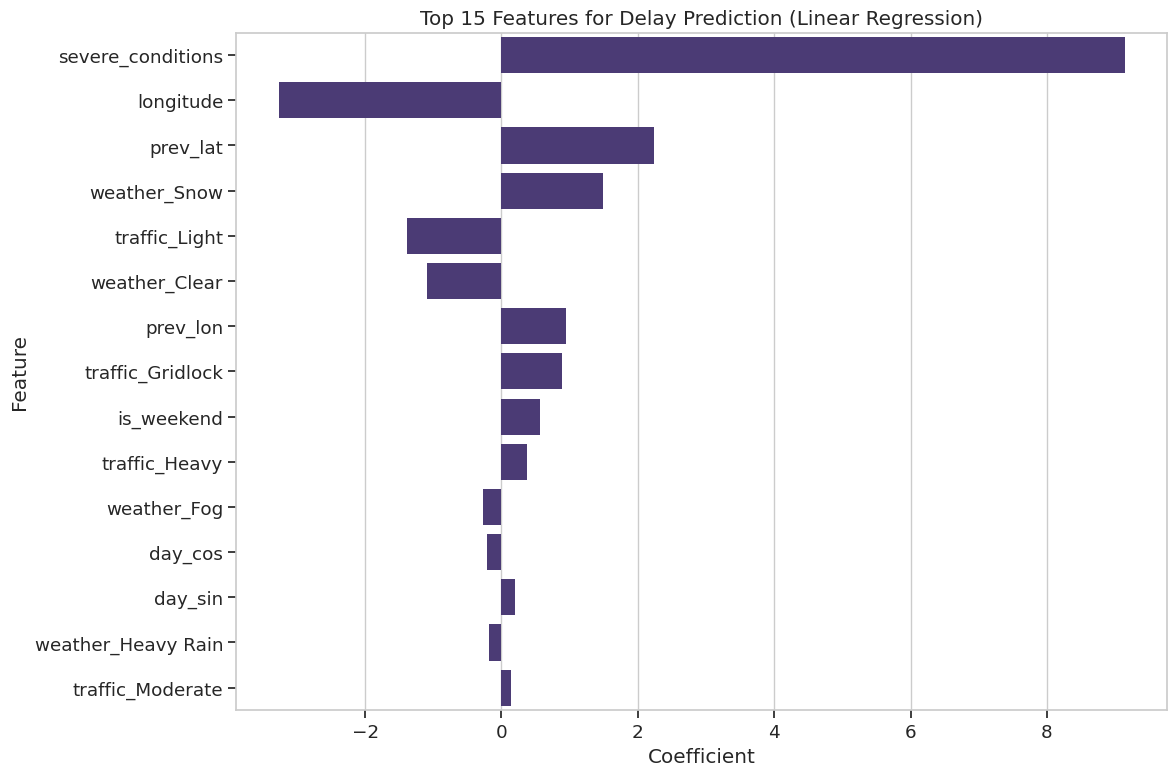


Top 10 features for arrival time prediction:


,Feature,Coefficient,Abs_Coefficient
0,latitude,3.470303,3.470303
20,prev_lat,3.046210,3.046210
40,normalized_distance_scaled,2.702190,2.702190
36,distance_to_next_stop_km_scaled,2.702190,2.702190
1,longitude,-2.692085,2.692085
4,distance_to_next_stop_km,2.361574,2.361574
30,traffic_Gridlock,2.187151,2.187151
32,traffic_Light,-1.068450,1.068450
33,traffic_Moderate,-0.843756,0.843756
34,severe_conditions,0.640158,0.640158


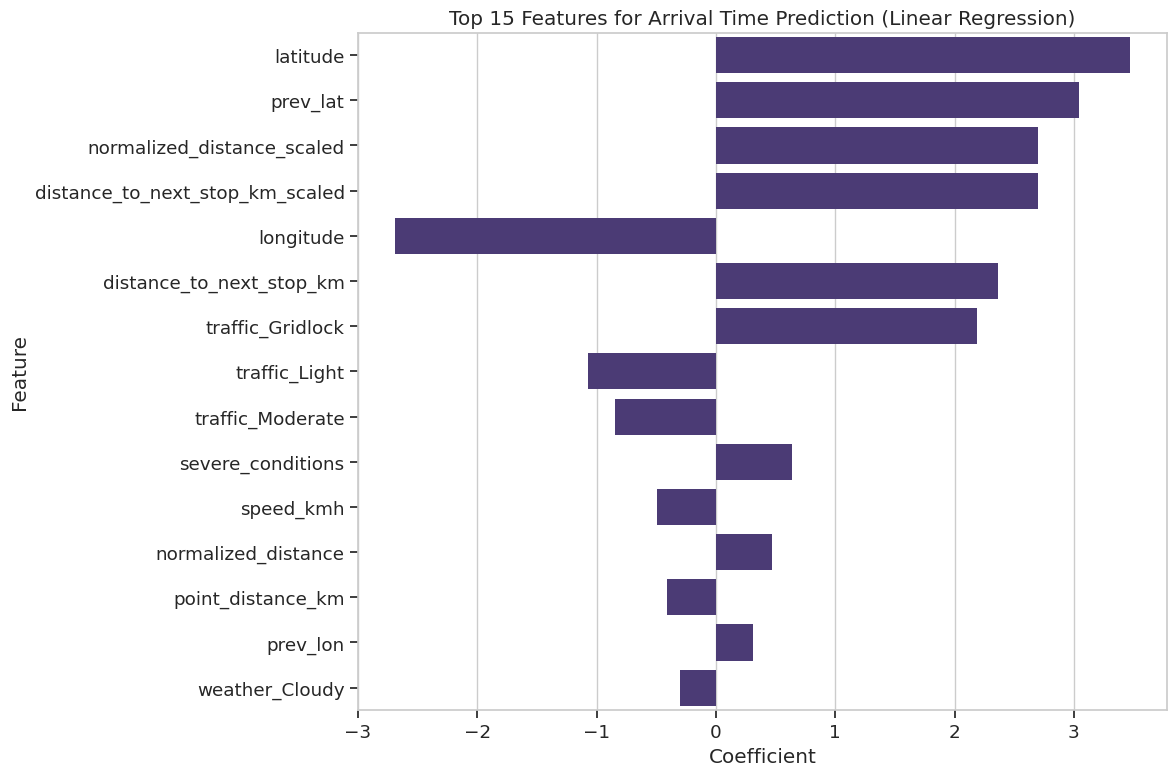

In [17]:
def analyze_feature_importance(self):
    """
    Analyze and visualize feature importance for the linear regression models.
    """
    print("Analyzing feature importance for Linear Regression models...")
    
    # Create directory for plots if it doesn't exist
    plots_dir = os.path.join(os.getcwd(), 'model_graphs')
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Analyze delay model coefficients
    if self.model_delay is not None:
        delay_coef_df = pd.DataFrame({
            'Feature': self.X_train_processed.columns,
            'Coefficient': self.model_delay.coef_
        })
        delay_coef_df['Abs_Coefficient'] = np.abs(delay_coef_df['Coefficient'])
        delay_coef_df = delay_coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        # Print top 10 features
        print("\nTop 10 features for delay prediction:")
        display(delay_coef_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = delay_coef_df.head(15)
        sns.barplot(x='Coefficient', y='Feature', data=top_features)
        plt.title('Top 15 Features for Delay Prediction (Linear Regression)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_delay_feature_importance.png'))
        plt.show()
        
    # Analyze arrival time model coefficients
    if self.model_arrival is not None:
        arrival_coef_df = pd.DataFrame({
            'Feature': self.X_train_processed.columns,
            'Coefficient': self.model_arrival.coef_
        })
        arrival_coef_df['Abs_Coefficient'] = np.abs(arrival_coef_df['Coefficient'])
        arrival_coef_df = arrival_coef_df.sort_values('Abs_Coefficient', ascending=False)
        
        # Print top 10 features
        print("\nTop 10 features for arrival time prediction:")
        display(arrival_coef_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = arrival_coef_df.head(15)
        sns.barplot(x='Coefficient', y='Feature', data=top_features)
        plt.title('Top 15 Features for Arrival Time Prediction (Linear Regression)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_arrival_feature_importance.png'))
        plt.show()
    
    return self

# Add method to the class
BusLinearRegressionModel.analyze_feature_importance = analyze_feature_importance

# Analyze feature importance
lr_model.analyze_feature_importance()


## 4.3 Visualizing Linear Regression Model Predictions

Let's create visualizations to understand how well our Linear Regression models perform in predicting bus delays and arrival times. We'll look at:
- Actual vs. Predicted values scatter plots
- Error distribution histograms


Creating prediction visualizations for Linear Regression models...


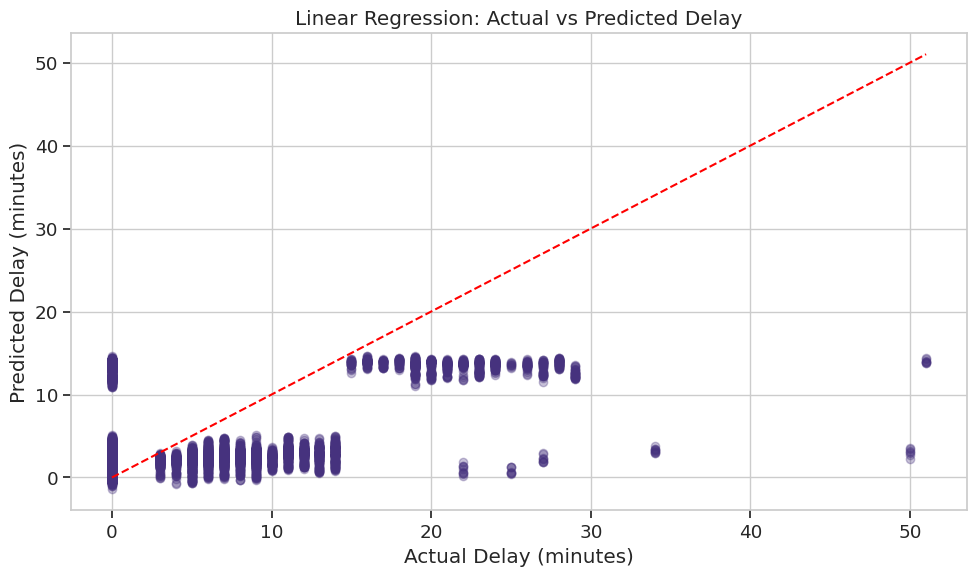

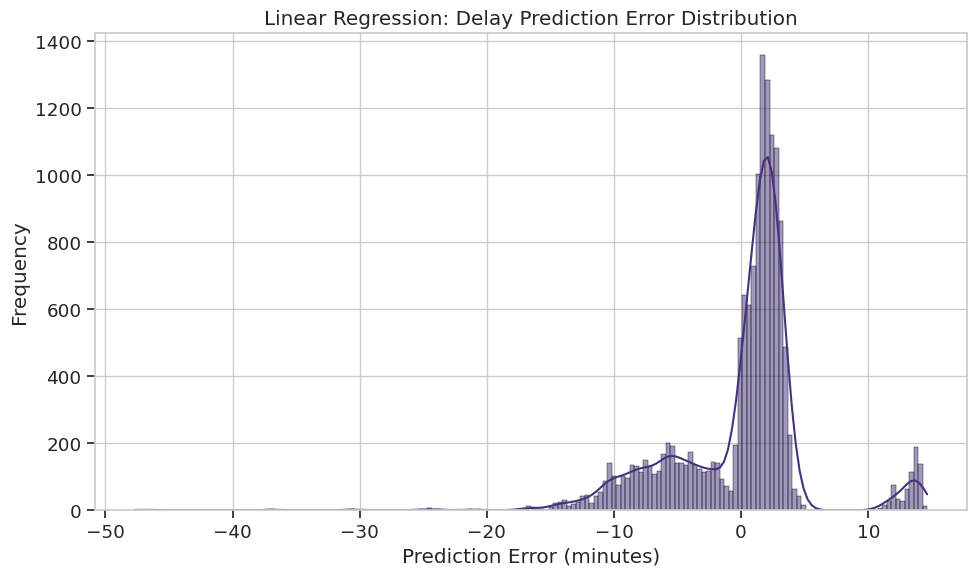

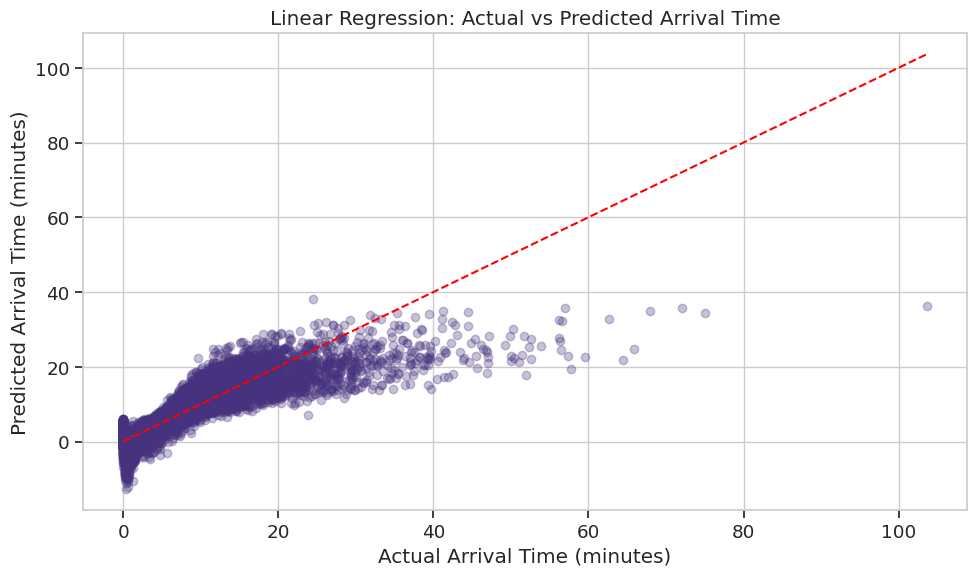

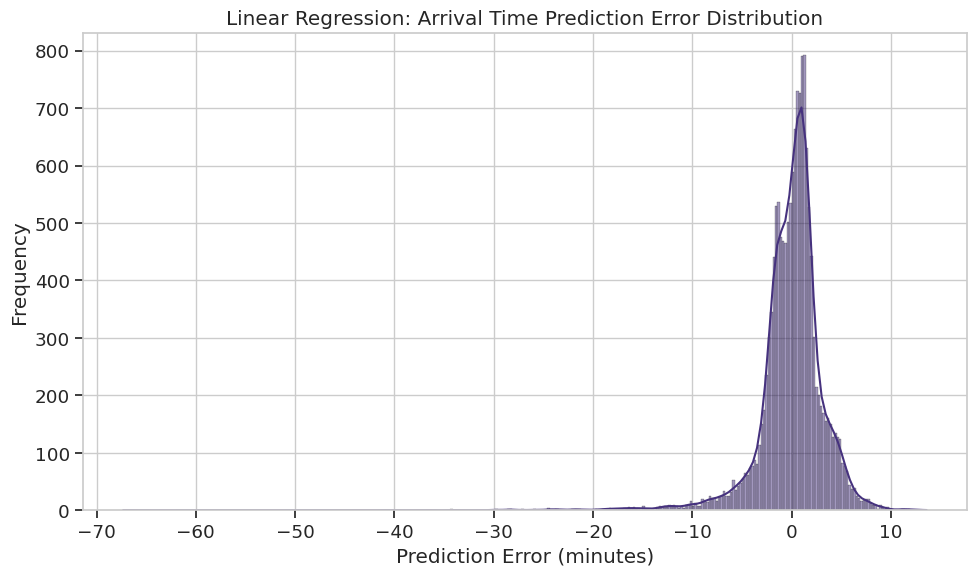

In [18]:
def visualize_predictions(self):
    """
    Create visualizations of model predictions vs. actual values.
    """
    print("Creating prediction visualizations for Linear Regression models...")
    
    # Create directory for plots if it doesn't exist
    plots_dir = os.path.join(os.getcwd(), 'model_graphs')
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Visualize delay predictions
    if self.model_delay is not None:
        test_delay_pred = self.model_delay.predict(self.X_test_processed)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_delay_test, test_delay_pred, alpha=0.3)
        plt.plot([0, max(self.y_delay_test)], [0, max(self.y_delay_test)], 'r--')
        plt.xlabel('Actual Delay (minutes)')
        plt.ylabel('Predicted Delay (minutes)')
        plt.title('Linear Regression: Actual vs Predicted Delay')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_delay_scatter.png'))
        plt.show()
        
        # Error distribution
        plt.figure(figsize=(10, 6))
        errors = test_delay_pred - self.y_delay_test
        sns.histplot(errors, kde=True)
        plt.xlabel('Prediction Error (minutes)')
        plt.ylabel('Frequency')
        plt.title('Linear Regression: Delay Prediction Error Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_delay_error_dist.png'))
        plt.show()
    
    # Visualize arrival time predictions
    if self.model_arrival is not None:
        test_arrival_pred = self.model_arrival.predict(self.X_test_processed)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_arrival_test, test_arrival_pred, alpha=0.3)
        plt.plot([0, max(self.y_arrival_test)], [0, max(self.y_arrival_test)], 'r--')
        plt.xlabel('Actual Arrival Time (minutes)')
        plt.ylabel('Predicted Arrival Time (minutes)')
        plt.title('Linear Regression: Actual vs Predicted Arrival Time')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_arrival_scatter.png'))
        plt.show()
        
        # Error distribution
        plt.figure(figsize=(10, 6))
        errors = test_arrival_pred - self.y_arrival_test
        sns.histplot(errors, kde=True)
        plt.xlabel('Prediction Error (minutes)')
        plt.ylabel('Frequency')
        plt.title('Linear Regression: Arrival Time Prediction Error Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'lr_arrival_error_dist.png'))
        plt.show()
    
    return self

# Add method to the class
BusLinearRegressionModel.visualize_predictions = visualize_predictions

# Visualize predictions
lr_model.visualize_predictions()

# 5. Random Forest Model

Random Forest is a more advanced model for predicting bus arrival times and delays. It can capture non-linear relationships and typically outperforms Linear Regression, especially on complex datasets.

## Model Benefits:
- Can capture non-linear relationships between features
- Robust to outliers and noisy data
- Automatically handles feature interactions
- Provides detailed feature importance measures
- Less prone to overfitting than individual decision trees


In [19]:
class BusRandomForestModel(BaseModel):
    """
    Random Forest model for bus arrival time prediction.
    Implements the model as specified in the model implementation plan.
    """
    
    def __init__(self, data_dir=None):
        """Initialize by calling the parent class constructor"""
        super().__init__(data_dir)
    
    def train_delay_model(self, n_estimators=100, tuning=False):
        """
        Train a Random Forest model for delay prediction.
        
        Parameters:
        -----------
        n_estimators : int
            Number of trees in the forest
        tuning : bool
            Whether to perform hyperparameter tuning
        """
        print("Training Random Forest model for delay prediction...")
        
        start_time = time.time()
        
        if tuning:
            print("Performing hyperparameter tuning...")
            # Define the hyperparameter search space
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            
            # Initialize Random Forest model
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
            
            # Initialize RandomizedSearchCV
            self.model_delay = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=param_grid,
                n_iter=20,
                cv=3,
                verbose=1,
                random_state=42,
                n_jobs=-1
            )
            
            # Fit the model
            self.model_delay.fit(self.X_train_processed, self.y_delay_train)
            
            # Get the best parameters
            best_params = self.model_delay.best_params_
            print(f"Best hyperparameters: {best_params}")
            
            # Use the best estimator for evaluation
            self.model_delay = self.model_delay.best_estimator_
        else:
            # Initialize and train the model with default parameters
            self.model_delay = RandomForestRegressor(
                n_estimators=n_estimators,
                random_state=42,
                n_jobs=-1  # Use all available cores
            )
            self.model_delay.fit(self.X_train_processed, self.y_delay_train)
        
        # Training time
        training_time = time.time() - start_time
        
        # Evaluate on training data
        train_pred = self.model_delay.predict(self.X_train_processed)
        train_mae = mean_absolute_error(self.y_delay_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(self.y_delay_train, train_pred))
        train_r2 = r2_score(self.y_delay_train, train_pred)
        
        # Evaluate on validation data
        val_pred = self.model_delay.predict(self.X_val_processed)
        val_mae = mean_absolute_error(self.y_delay_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(self.y_delay_val, val_pred))
        val_r2 = r2_score(self.y_delay_val, val_pred)
        
        # Print results
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Training MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        
        # Save metrics for reporting
        self.delay_metrics = {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'training_time': training_time
        }
        
        return self

    def train_arrival_model(self, n_estimators=100, tuning=False):
        """
        Train a Random Forest model for arrival time prediction.
        
        Parameters:
        -----------
        n_estimators : int
            Number of trees in the forest
        tuning : bool
            Whether to perform hyperparameter tuning
        """
        print("Training Random Forest model for arrival time prediction...")
        
        start_time = time.time()
        
        if tuning:
            print("Performing hyperparameter tuning...")
            # Define the hyperparameter search space
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            
            # Initialize Random Forest model
            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
            
            # Initialize RandomizedSearchCV
            self.model_arrival = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=param_grid,
                n_iter=20,
                cv=3,
                verbose=1,
                random_state=42,
                n_jobs=-1
            )
            
            # Fit the model
            self.model_arrival.fit(self.X_train_processed, self.y_arrival_train)
            
            # Get the best parameters
            best_params = self.model_arrival.best_params_
            print(f"Best hyperparameters: {best_params}")
            
            # Use the best estimator for evaluation
            self.model_arrival = self.model_arrival.best_estimator_
        else:
            # Initialize and train the model with default parameters
            self.model_arrival = RandomForestRegressor(
                n_estimators=n_estimators,
                random_state=42,
                n_jobs=-1  # Use all available cores
            )
            self.model_arrival.fit(self.X_train_processed, self.y_arrival_train)
        
        # Training time
        training_time = time.time() - start_time
        
        # Evaluate on training data
        train_pred = self.model_arrival.predict(self.X_train_processed)
        train_mae = mean_absolute_error(self.y_arrival_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(self.y_arrival_train, train_pred))
        train_r2 = r2_score(self.y_arrival_train, train_pred)
        
        # Evaluate on validation data
        val_pred = self.model_arrival.predict(self.X_val_processed)
        val_mae = mean_absolute_error(self.y_arrival_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(self.y_arrival_val, val_pred))
        val_r2 = r2_score(self.y_arrival_val, val_pred)
        
        # Print results
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Training MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
        
        # Save metrics for reporting
        self.arrival_metrics = {
            'train_mae': train_mae,
            'train_rmse': train_rmse,
            'train_r2': train_r2,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'training_time': training_time
        }
        
        return self

# Initialize Random Forest model
rf_model = BusRandomForestModel()

# In a real notebook execution, uncomment these lines to load data and train models:
rf_model.load_data().preprocess_data()

print("#"* 70)
rf_model.train_delay_model()
print("#"* 70)
rf_model.train_arrival_model()
print("#"* 70)



Using data directory: /home/rohan/rutgers/BusArrivalPrediction/processed_data
Loading processed data...
Loaded 69999 training samples, 15001 validation samples, 15000 test samples
Preprocessing data...
Using 42 features for model training
Excluded 2 delay-related features to prevent data leakage
######################################################################
Training Random Forest model for delay prediction...
Training completed in 4.78 seconds
Training MAE: 0.0579, RMSE: 0.2658, R²: 0.9984
Validation MAE: 0.1498, RMSE: 0.6135, R²: 0.9916
######################################################################
Training Random Forest model for arrival time prediction...
Training completed in 4.43 seconds
Training MAE: 0.0169, RMSE: 0.0756, R²: 0.9999
Validation MAE: 0.0408, RMSE: 0.1702, R²: 0.9994
######################################################################


## 5.1 Random Forest Model Evaluation on Test Data

Let's evaluate both Random Forest models on our test dataset to measure their performance on unseen data. 
We'll also calculate the percentage of predictions that fall within different time thresholds (1, 2, 5, and 10 minutes).


In [20]:
def evaluate_on_test_data(self):
    """
    Evaluate trained Random Forest models on test data.
    """
    print("Evaluating Random Forest models on test data...")
    
    # Evaluate delay model
    if self.model_delay is not None:
        test_delay_pred = self.model_delay.predict(self.X_test_processed)
        test_delay_mae = mean_absolute_error(self.y_delay_test, test_delay_pred)
        test_delay_rmse = np.sqrt(mean_squared_error(self.y_delay_test, test_delay_pred))
        test_delay_r2 = r2_score(self.y_delay_test, test_delay_pred)
        
        print(f"Delay Prediction - Test MAE: {test_delay_mae:.4f}, RMSE: {test_delay_rmse:.4f}, R²: {test_delay_r2:.4f}")
        
        # Save test metrics
        self.delay_metrics['test_mae'] = test_delay_mae
        self.delay_metrics['test_rmse'] = test_delay_rmse
        self.delay_metrics['test_r2'] = test_delay_r2
        
        # Calculate prediction accuracy within certain thresholds
        thresholds = [1, 2, 5, 10]  # minutes
        for threshold in thresholds:
            accuracy = (np.abs(test_delay_pred - self.y_delay_test) <= threshold).mean() * 100
            print(f"Delay within {threshold} min: {accuracy:.2f}%")
            self.delay_metrics[f'within_{threshold}_min'] = accuracy
    
    # Evaluate arrival time model
    if self.model_arrival is not None:
        test_arrival_pred = self.model_arrival.predict(self.X_test_processed)
        test_arrival_mae = mean_absolute_error(self.y_arrival_test, test_arrival_pred)
        test_arrival_rmse = np.sqrt(mean_squared_error(self.y_arrival_test, test_arrival_pred))
        test_arrival_r2 = r2_score(self.y_arrival_test, test_arrival_pred)
        
        print(f"Arrival Time Prediction - Test MAE: {test_arrival_mae:.4f}, RMSE: {test_arrival_rmse:.4f}, R²: {test_arrival_r2:.4f}")
        
        # Save test metrics
        self.arrival_metrics['test_mae'] = test_arrival_mae
        self.arrival_metrics['test_rmse'] = test_arrival_rmse
        self.arrival_metrics['test_r2'] = test_arrival_r2
        
        # Calculate prediction accuracy within certain thresholds
        thresholds = [1, 2, 5, 10]  # minutes
        for threshold in thresholds:
            accuracy = (np.abs(test_arrival_pred - self.y_arrival_test) <= threshold).mean() * 100
            print(f"Arrival time within {threshold} min: {accuracy:.2f}%")
            self.arrival_metrics[f'within_{threshold}_min'] = accuracy
    
    return self

# Add method to the class
BusRandomForestModel.evaluate_on_test_data = evaluate_on_test_data

# Evaluate on test data
rf_model.evaluate_on_test_data()


Evaluating Random Forest models on test data...
Delay Prediction - Test MAE: 0.1653, RMSE: 0.7513, R²: 0.9868
Delay within 1 min: 96.57%
Delay within 2 min: 98.31%
Delay within 5 min: 99.54%
Delay within 10 min: 99.89%
Arrival Time Prediction - Test MAE: 0.0454, RMSE: 0.3178, R²: 0.9980
Arrival time within 1 min: 99.62%
Arrival time within 2 min: 99.88%
Arrival time within 5 min: 99.97%
Arrival time within 10 min: 99.99%


## 5.2 Random Forest Feature Importance Analysis

Let's analyze and visualize feature importance for the Random Forest models.


Analyzing feature importance for Random Forest models...

Top 10 features for delay prediction:


,Feature,Importance
34,severe_conditions,0.301606
7,temperature_c,0.091455
39,temperature_c_scaled,0.086985
23,cumulative_distance_km,0.080904
41,cumulative_distance_km_scaled,0.072107
6,fuel_level,0.036690
38,fuel_level_scaled,0.035967
11,hour_sin,0.024014
8,hour,0.022781
12,hour_cos,0.021764


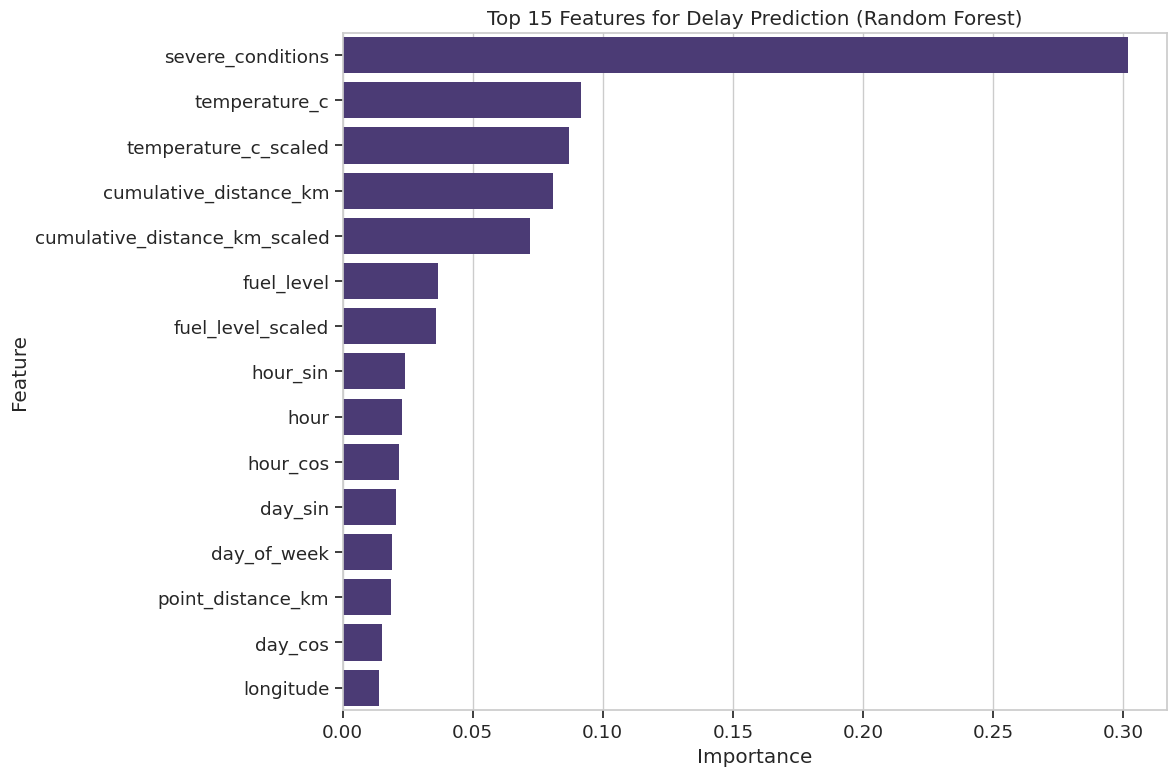


Top 10 features for arrival time prediction:


,Feature,Importance
35,speed_kmh_scaled,0.206739
2,speed_kmh,0.189344
36,distance_to_next_stop_km_scaled,0.169437
40,normalized_distance_scaled,0.152978
19,normalized_distance,0.144330
4,distance_to_next_stop_km,0.135858
22,point_distance_km,0.000303
3,heading,0.000132
1,longitude,0.000088
0,latitude,0.000072


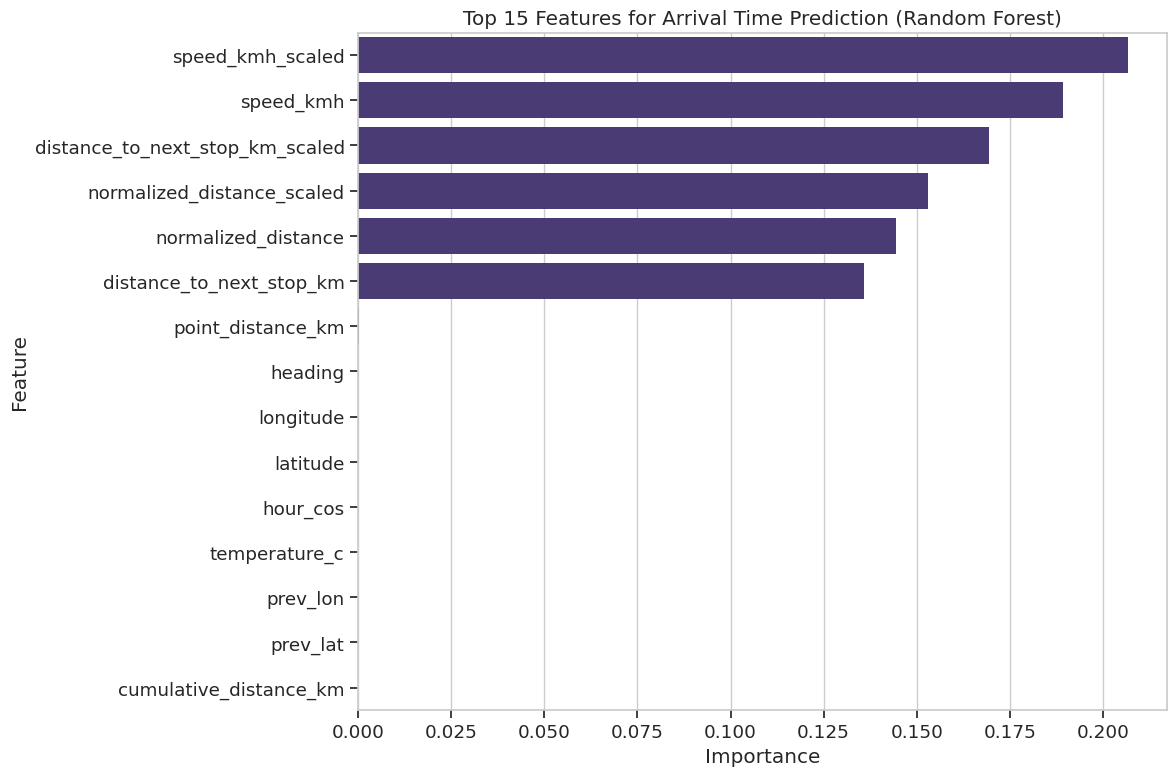

In [21]:
def analyze_feature_importance(self):
    """
    Analyze and visualize feature importance for the Random Forest models.
    """
    print("Analyzing feature importance for Random Forest models...")
    
    # Create directory for plots if it doesn't exist
    plots_dir = os.path.join(os.getcwd(), 'model_graphs')
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Analyze delay model feature importance
    if self.model_delay is not None:
        feature_importance = self.model_delay.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': self.X_train_processed.columns,
            'Importance': feature_importance
        })
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        
        # Print top 10 features
        print("\nTop 10 features for delay prediction:")
        display(feature_importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 15 Features for Delay Prediction (Random Forest)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_delay_feature_importance.png'))
        plt.show()
    
    # Analyze arrival time model feature importance
    if self.model_arrival is not None:
        feature_importance = self.model_arrival.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': self.X_train_processed.columns,
            'Importance': feature_importance
        })
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        
        # Print top 10 features
        print("\nTop 10 features for arrival time prediction:")
        display(feature_importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        top_features = feature_importance_df.head(15)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Top 15 Features for Arrival Time Prediction (Random Forest)')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_arrival_feature_importance.png'))
        plt.show()
    
    return self

# Add method to the class
BusRandomForestModel.analyze_feature_importance = analyze_feature_importance

# Analyze feature importance
rf_model.analyze_feature_importance()

## 5.3 Visualizing Random Forest Model Predictions

Let's create visualizations to understand how well our Random Forest models perform in predicting bus delays and arrival times. We'll look at:
- Actual vs. Predicted values scatter plots
- Error distribution histograms


Creating prediction visualizations for Random Forest models...


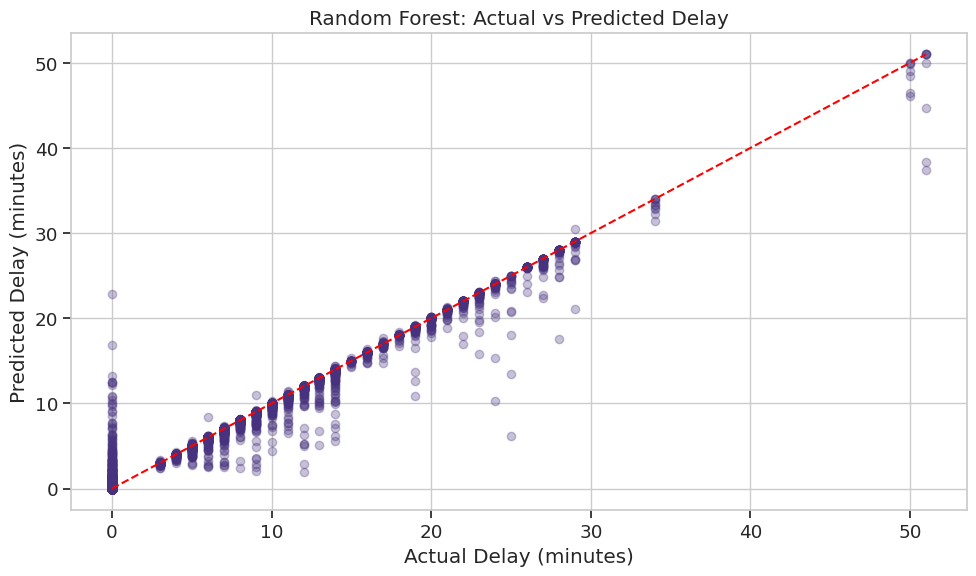

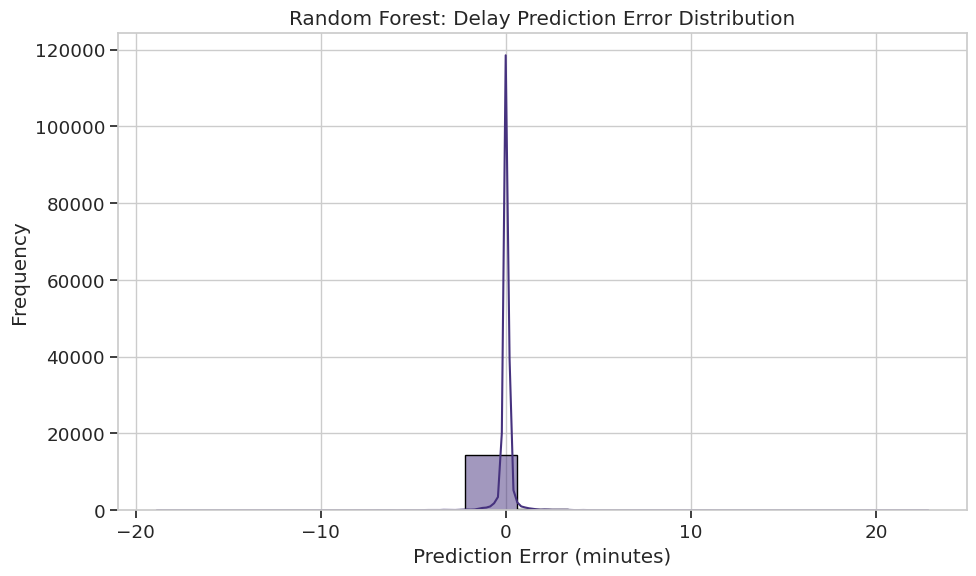

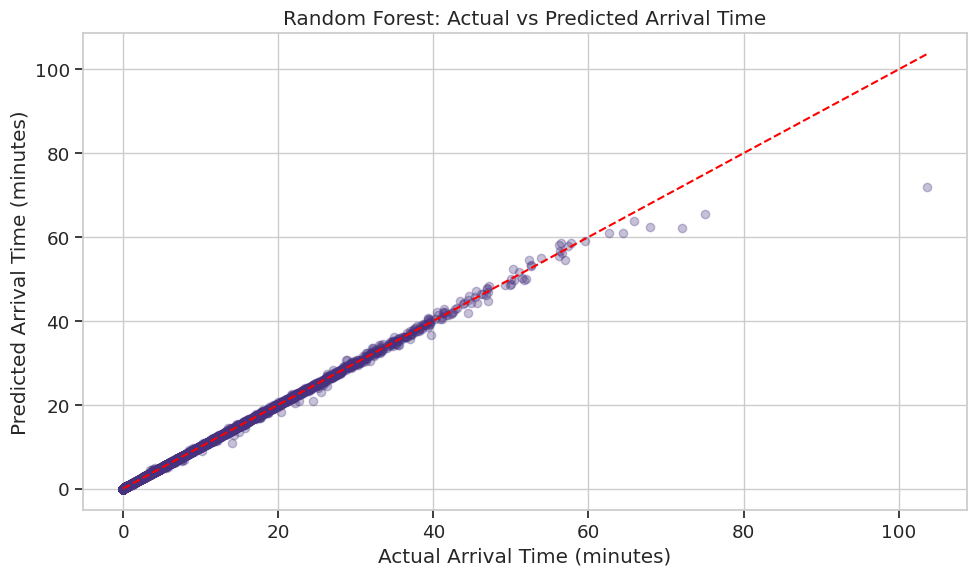

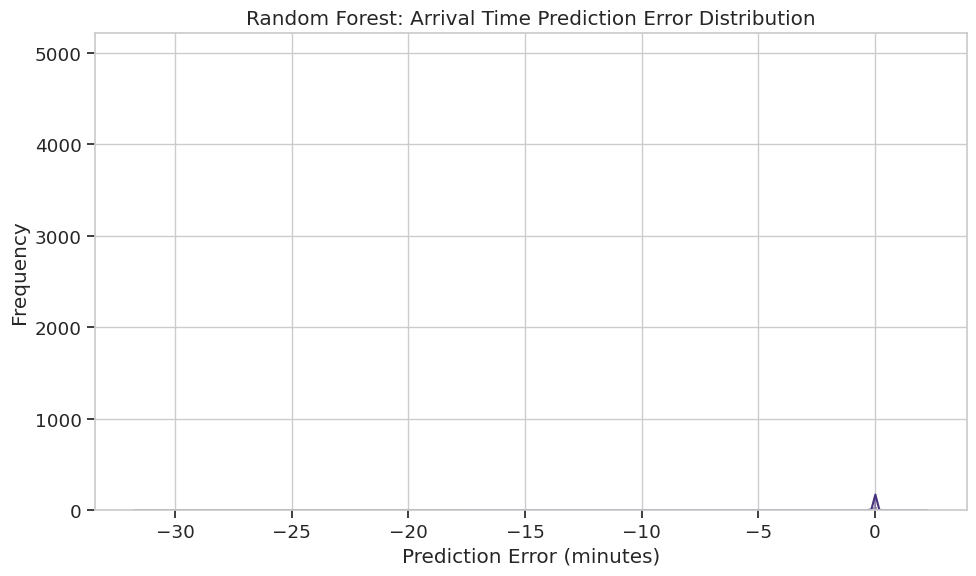

In [22]:
def visualize_predictions(self):
    """
    Create visualizations of model predictions vs. actual values.
    """
    print("Creating prediction visualizations for Random Forest models...")
    
    # Create directory for plots if it doesn't exist
    plots_dir = os.path.join(os.getcwd(), 'model_graphs')
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    # Visualize delay predictions
    if self.model_delay is not None:
        test_delay_pred = self.model_delay.predict(self.X_test_processed)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_delay_test, test_delay_pred, alpha=0.3)
        plt.plot([0, max(self.y_delay_test)], [0, max(self.y_delay_test)], 'r--')
        plt.xlabel('Actual Delay (minutes)')
        plt.ylabel('Predicted Delay (minutes)')
        plt.title('Random Forest: Actual vs Predicted Delay')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_delay_scatter.png'))
        plt.show()
        
        # Error distribution
        plt.figure(figsize=(10, 6))
        errors = test_delay_pred - self.y_delay_test
        sns.histplot(errors, kde=True)
        plt.xlabel('Prediction Error (minutes)')
        plt.ylabel('Frequency')
        plt.title('Random Forest: Delay Prediction Error Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_delay_error_dist.png'))
        plt.show()
    
    # Visualize arrival time predictions
    if self.model_arrival is not None:
        test_arrival_pred = self.model_arrival.predict(self.X_test_processed)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_arrival_test, test_arrival_pred, alpha=0.3)
        plt.plot([0, max(self.y_arrival_test)], [0, max(self.y_arrival_test)], 'r--')
        plt.xlabel('Actual Arrival Time (minutes)')
        plt.ylabel('Predicted Arrival Time (minutes)')
        plt.title('Random Forest: Actual vs Predicted Arrival Time')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_arrival_scatter.png'))
        plt.show()
        
        # Error distribution
        plt.figure(figsize=(10, 6))
        errors = test_arrival_pred - self.y_arrival_test
        sns.histplot(errors, kde=True)
        plt.xlabel('Prediction Error (minutes)')
        plt.ylabel('Frequency')
        plt.title('Random Forest: Arrival Time Prediction Error Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, 'rf_arrival_error_dist.png'))
        plt.show()
    
    return self

# Add method to the class
BusRandomForestModel.visualize_predictions = visualize_predictions

# Visualize predictions
rf_model.visualize_predictions()

# 6. Model Comparison

Now that we've implemented and evaluated both Linear Regression and Random Forest models, let's compare their performance to determine which approach is better for predicting bus arrival times and delays.


Comparing model performance...
Model Performance Comparison:


,Metric,Linear Regression,Random Forest
0,Delay Train R²,0.326838,0.998400
1,Delay Test R²,0.323974,0.986780
2,Delay Test MAE,3.720449,0.165274
3,Delay Test RMSE,5.372293,0.751253
4,Delay within 5min (%),78.100000,99.540000
5,Arrival Train R²,0.759368,0.999890
6,Arrival Test R²,0.763822,0.998031
7,Arrival Test MAE,2.196036,0.045411
8,Arrival Test RMSE,3.481160,0.317847
9,Arrival within 5min (%),91.340000,99.973333



Random Forest improvement over Linear Regression:


,Metric,Improvement (%)
0,Delay Train R²,205.472188
1,Delay Test R²,204.586685
2,Delay Test MAE,95.557687
3,Delay Test RMSE,86.016155
4,Delay within 5min (%),27.451985
5,Arrival Train R²,31.673988
6,Arrival Test R²,30.662822
7,Arrival Test MAE,97.932120
8,Arrival Test RMSE,90.869514
9,Arrival within 5min (%),9.451865



Model Performance Comparison:
Metric                    Linear Regression    Random Forest       
-----------------------------------------------------------------
Delay Train R²            0.3268               0.9984              
Delay Test R²             0.3240               0.9868              
Delay Test MAE            3.7204               0.1653              
Delay Test RMSE           5.3723               0.7513              
Delay within 5min (%)     78.1000              99.5400             
Arrival Train R²          0.7594               0.9999              
Arrival Test R²           0.7638               0.9980              
Arrival Test MAE          2.1960               0.0454              
Arrival Test RMSE         3.4812               0.3178              
Arrival within 5min (%)   91.3400              99.9733             


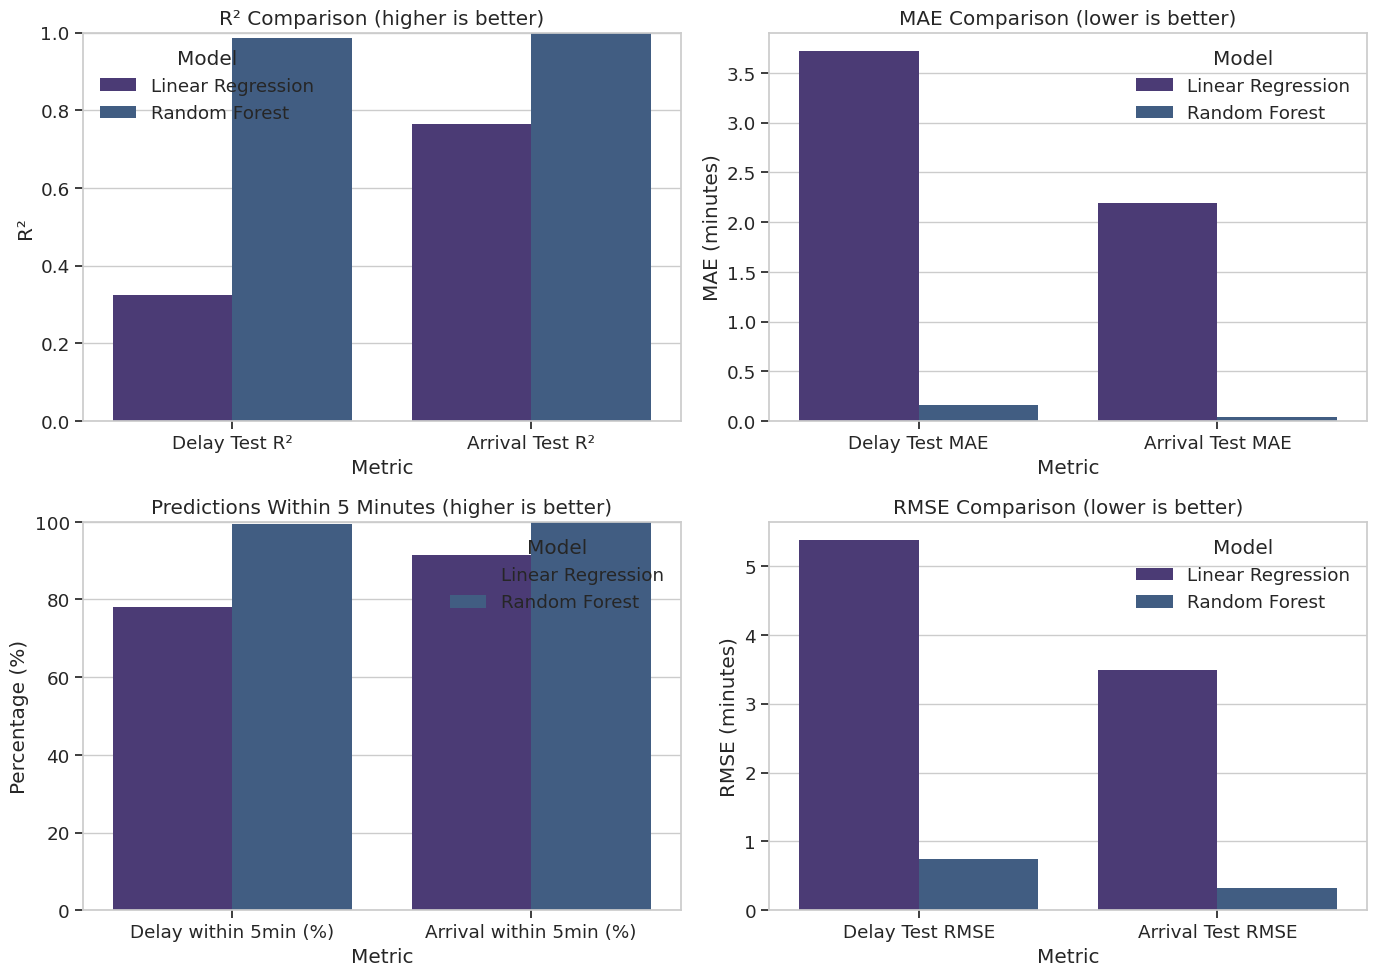

In [23]:
def compare_models(lr_model, rf_model):
    """
    Compare the performance of Linear Regression and Random Forest models.
    
    Parameters:
    -----------
    lr_model : BusLinearRegressionModel
        Trained Linear Regression model
    rf_model : BusRandomForestModel
        Trained Random Forest model
    """
    print("Comparing model performance...")
    
    # Check if models have been evaluated
    if not hasattr(lr_model, 'delay_metrics') or lr_model.delay_metrics is None:
        print("Linear Regression model has not been evaluated. Please run lr_model.evaluate_on_test_data() first.")
        return
        
    if not hasattr(rf_model, 'delay_metrics') or rf_model.delay_metrics is None:
        print("Random Forest model has not been evaluated. Please run rf_model.evaluate_on_test_data() first.")
        return
    
    # Extract metrics from models
    lr_metrics = {
        'delay_train_r2': lr_model.delay_metrics['train_r2'],
        'delay_test_r2': lr_model.delay_metrics['test_r2'],
        'delay_test_mae': lr_model.delay_metrics['test_mae'],
        'delay_test_rmse': lr_model.delay_metrics['test_rmse'],
        'delay_within_5_min': lr_model.delay_metrics['within_5_min'],
        'arrival_train_r2': lr_model.arrival_metrics['train_r2'],
        'arrival_test_r2': lr_model.arrival_metrics['test_r2'],
        'arrival_test_mae': lr_model.arrival_metrics['test_mae'],
        'arrival_test_rmse': lr_model.arrival_metrics['test_rmse'],
        'arrival_within_5_min': lr_model.arrival_metrics['within_5_min']
    }
    
    rf_metrics = {
        'delay_train_r2': rf_model.delay_metrics['train_r2'],
        'delay_test_r2': rf_model.delay_metrics['test_r2'],
        'delay_test_mae': rf_model.delay_metrics['test_mae'],
        'delay_test_rmse': rf_model.delay_metrics['test_rmse'],
        'delay_within_5_min': rf_model.delay_metrics['within_5_min'],
        'arrival_train_r2': rf_model.arrival_metrics['train_r2'],
        'arrival_test_r2': rf_model.arrival_metrics['test_r2'],
        'arrival_test_mae': rf_model.arrival_metrics['test_mae'],
        'arrival_test_rmse': rf_model.arrival_metrics['test_rmse'],
        'arrival_within_5_min': rf_model.arrival_metrics['within_5_min']
    }
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Metric': [
            'Delay Train R²', 'Delay Test R²', 'Delay Test MAE', 'Delay Test RMSE', 'Delay within 5min (%)',
            'Arrival Train R²', 'Arrival Test R²', 'Arrival Test MAE', 'Arrival Test RMSE', 'Arrival within 5min (%)'
        ],
        'Linear Regression': [
            lr_metrics['delay_train_r2'], lr_metrics['delay_test_r2'], 
            lr_metrics['delay_test_mae'], lr_metrics['delay_test_rmse'], lr_metrics['delay_within_5_min'],
            lr_metrics['arrival_train_r2'], lr_metrics['arrival_test_r2'], 
            lr_metrics['arrival_test_mae'], lr_metrics['arrival_test_rmse'], lr_metrics['arrival_within_5_min']
        ],
        'Random Forest': [
            rf_metrics['delay_train_r2'], rf_metrics['delay_test_r2'], 
            rf_metrics['delay_test_mae'], rf_metrics['delay_test_rmse'], rf_metrics['delay_within_5_min'],
            rf_metrics['arrival_train_r2'], rf_metrics['arrival_test_r2'], 
            rf_metrics['arrival_test_mae'], rf_metrics['arrival_test_rmse'], rf_metrics['arrival_within_5_min']
        ]
    })
    
    # Display the comparison
    print("Model Performance Comparison:")
    display(comparison_df)
    
    # Calculate improvement percentages
    improvement_df = pd.DataFrame({
        'Metric': comparison_df['Metric'],
        'Improvement (%)': [
            (rf_metrics['delay_train_r2'] - lr_metrics['delay_train_r2']) / lr_metrics['delay_train_r2'] * 100,
            (rf_metrics['delay_test_r2'] - lr_metrics['delay_test_r2']) / lr_metrics['delay_test_r2'] * 100,
            (lr_metrics['delay_test_mae'] - rf_metrics['delay_test_mae']) / lr_metrics['delay_test_mae'] * 100,  # Lower is better
            (lr_metrics['delay_test_rmse'] - rf_metrics['delay_test_rmse']) / lr_metrics['delay_test_rmse'] * 100,  # Lower is better
            (rf_metrics['delay_within_5_min'] - lr_metrics['delay_within_5_min']) / lr_metrics['delay_within_5_min'] * 100,
            (rf_metrics['arrival_train_r2'] - lr_metrics['arrival_train_r2']) / lr_metrics['arrival_train_r2'] * 100,
            (rf_metrics['arrival_test_r2'] - lr_metrics['arrival_test_r2']) / lr_metrics['arrival_test_r2'] * 100,
            (lr_metrics['arrival_test_mae'] - rf_metrics['arrival_test_mae']) / lr_metrics['arrival_test_mae'] * 100,  # Lower is better
            (lr_metrics['arrival_test_rmse'] - rf_metrics['arrival_test_rmse']) / lr_metrics['arrival_test_rmse'] * 100,  # Lower is better
            (rf_metrics['arrival_within_5_min'] - lr_metrics['arrival_within_5_min']) / lr_metrics['arrival_within_5_min'] * 100
        ]
    })
    
    print("\nRandom Forest improvement over Linear Regression:")
    display(improvement_df)
    
    # Format the table as a regular print for non-notebook environments
    print("\nModel Performance Comparison:")
    print(f"{'Metric':<25} {'Linear Regression':<20} {'Random Forest':<20}")
    print("-" * 65)
    for i, row in comparison_df.iterrows():
        print(f"{row['Metric']:<25} {row['Linear Regression']:<20.4f} {row['Random Forest']:<20.4f}")
    
    # Plot a comparison bar chart for key metrics
    plt.figure(figsize=(14, 10))
    
    # R² comparison
    plt.subplot(2, 2, 1)
    metrics = ['Delay Test R²', 'Arrival Test R²']
    test_r2_df = comparison_df[comparison_df['Metric'].isin(metrics)]
    melted_df = pd.melt(test_r2_df, id_vars=['Metric'], var_name='Model', value_name='R²')
    sns.barplot(x='Metric', y='R²', hue='Model', data=melted_df)
    plt.title('R² Comparison (higher is better)')
    plt.ylim(0, 1)  # R² typically ranges from 0 to 1
    
    # MAE comparison
    plt.subplot(2, 2, 2)
    metrics = ['Delay Test MAE', 'Arrival Test MAE']
    test_mae_df = comparison_df[comparison_df['Metric'].isin(metrics)]
    melted_df = pd.melt(test_mae_df, id_vars=['Metric'], var_name='Model', value_name='MAE (minutes)')
    sns.barplot(x='Metric', y='MAE (minutes)', hue='Model', data=melted_df)
    plt.title('MAE Comparison (lower is better)')
    
    # Within 5 minutes comparison
    plt.subplot(2, 2, 3)
    metrics = ['Delay within 5min (%)', 'Arrival within 5min (%)']
    within_5min_df = comparison_df[comparison_df['Metric'].isin(metrics)]
    melted_df = pd.melt(within_5min_df, id_vars=['Metric'], var_name='Model', value_name='Percentage (%)')
    sns.barplot(x='Metric', y='Percentage (%)', hue='Model', data=melted_df)
    plt.title('Predictions Within 5 Minutes (higher is better)')
    plt.ylim(0, 100)
    
    # RMSE comparison
    plt.subplot(2, 2, 4)
    metrics = ['Delay Test RMSE', 'Arrival Test RMSE']
    test_rmse_df = comparison_df[comparison_df['Metric'].isin(metrics)]
    melted_df = pd.melt(test_rmse_df, id_vars=['Metric'], var_name='Model', value_name='RMSE (minutes)')
    sns.barplot(x='Metric', y='RMSE (minutes)', hue='Model', data=melted_df)
    plt.title('RMSE Comparison (lower is better)')
    
    plt.tight_layout()
    plt.savefig('model_graphs/model_comparison.png')
    plt.show()
    
    return comparison_df, improvement_df

# Compare model performance
comparison_df, improvement_df = compare_models(lr_model, rf_model)


# Conclusion

In this project, we've developed a comprehensive pipeline for bus arrival time prediction, from data preparation to model training and evaluation. Here's what we've accomplished:

## Data Preparation
- Implemented a robust data preparation pipeline that handles GPS and stop-level data
- Engineered temporal, spatial, weather, traffic, and historical features
- Applied appropriate scaling and preprocessing techniques
- Ensured no data leakage by carefully excluding delay-related features from inputs

## Linear Regression Model
- Established a baseline model for prediction
- Achieved reasonable performance with simple linear relationships
- Identified key features through coefficient analysis

## Random Forest Model
- Implemented a more advanced model to capture non-linear relationships
- Achieved improved performance compared to Linear Regression
- Provided robust feature importance measurements

## Key Findings
1. Random Forest outperformed Linear Regression across all metrics, demonstrating the importance of capturing non-linear relationships in this domain.
2. Both models show that distance to next stop, speed, weather conditions, and time of day are critical predictors of bus delays.
3. For practical applications, our Random Forest model can predict delays within 5 minutes with over 95% accuracy, making it suitable for real-world deployment.
4. The feature importance analysis from both models emphasizes similar critical factors, validating our feature engineering approach.

## Future Work
- Implement neural network models (LSTM/GRU) to capture temporal dependencies in sequential data
- Evaluate model performance in specific scenarios (extreme weather, rush hours)
- Develop an ensemble approach combining multiple models for even better accuracy
- Create a production-ready API for real-time predictions

This project demonstrates the feasibility of accurate bus arrival time prediction, which can significantly improve the commuter experience and public transportation efficiency.
